# Task 1: Exploratory Data Analysis (EDA)
**Project:** Nova Financial Solutions - Sentiment & Stock Analysis  

---

###  Objectives
1. **Descriptive Statistics:** Analyze distribution of headline lengths and publisher activity.
2. **Time Series Analysis:** Detect publication trends and correlation with market hours.
3. **Sentiment & NLP:** Extract common keywords to understand market narratives.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
try:
    df = pd.read_csv('../data/newsData/raw_analyst_ratings.csv')
    print("News data loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Check the 'data/newsData' folder.")


News data loaded successfully!


## Descriptive statistics

Compute basic numeric summaries for headline length, top publishers and date range.


In [13]:
# Date Formatting
# Convert date string to datetime object
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['publication_date'] = df['date'].dt.date

In [14]:
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')

# --- DESCRIPTIVE STATISTICS ---

# 1. Headline length statistics
df['headline_length'] = df['headline'].astype(str).apply(len)
headline_stats = df['headline_length'].describe()

# 2. Top publishers
top_publishers = df['publisher'].astype(str).value_counts().head(20)

# 3. Date range (safe)
date_min = df['publication_date'].min()
date_max = df['publication_date'].max()

# --- PRINT RESULTS ---
print("Headline length stats:")
print(headline_stats.to_string())

print("\nTop publishers:")
print(top_publishers.to_string())

print(f"\nDate range: {date_min} to {date_max}")


Headline length stats:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02

Top publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590

Date range: 2011-04-28 00:00:00 to 2020-06-11 00:00:00


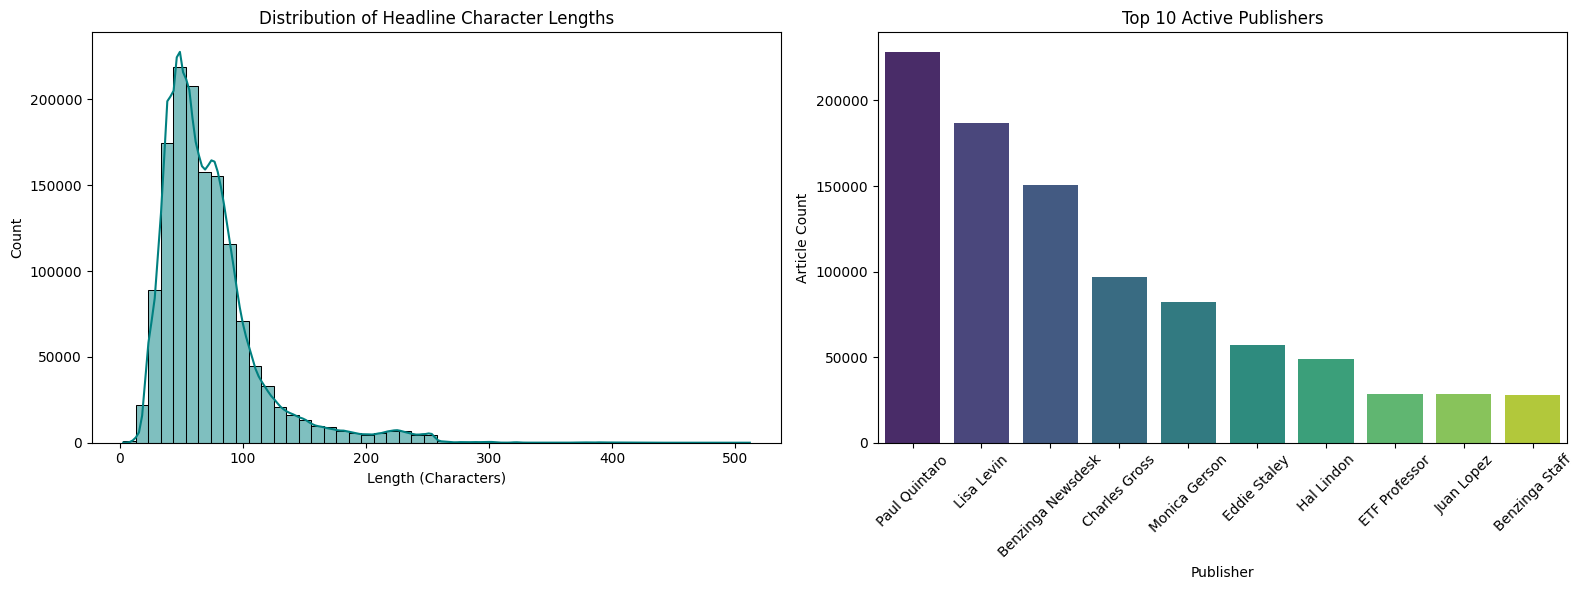

🔹 Average Headline Length: 73.1 chars
🔹 Median Headline Length: 64.0 chars


In [7]:
df['headline_len'] = df['headline'].astype(str).apply(len)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram of headline lengths
sns.histplot(df['headline_len'], bins=50, kde=True, color='teal', ax=ax[0])
ax[0].set_title('Distribution of Headline Character Lengths')
ax[0].set_xlabel('Length (Characters)')
ax[0].set_ylabel('Count')

# 2. Top 10 publishers on x-axis
top_publishers = df['publisher'].value_counts().head(10)
sns.barplot(
    x=top_publishers.index,
    y=top_publishers.values,
    hue=top_publishers.index,
    palette='viridis',
    legend=False,
    ax=ax[1]
)

ax[1].set_title('Top 10 Active Publishers')
ax[1].set_xlabel('Publisher')
ax[1].set_ylabel('Article Count')
ax[1].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

plt.tight_layout()
plt.show()

print(f"🔹 Average Headline Length: {df['headline_len'].mean():.1f} chars")
print(f"🔹 Median Headline Length: {df['headline_len'].median():.1f} chars")


## Time series analysis

- Resample articles per day
- Detect top spike days
- Analyze publishing hours to see when most articles are released


Articles per day (non-zero):
publication_date
2011-04-28      3
2011-04-29      2
2011-04-30      1
2011-05-01      1
2011-05-02      9
2011-05-03      3
2011-05-05      3
2011-05-06      3
2011-05-07      1
2011-05-08      1
2011-05-09      3
2011-05-11      3
2011-05-12      1
2011-05-13      4
2011-05-15      1
2011-05-16      3
2011-05-17      4
2011-05-18      3
2011-05-19      2
2011-05-20      1
2011-05-22      2
2011-05-23      3
2011-05-24      4
2011-05-25      9
2011-05-26      2
2011-05-27      3
2011-05-29      1
2011-05-30      1
2011-05-31      7
2011-06-01      3
2011-06-02      1
2011-06-03      3
2011-06-06      4
2011-06-07      8
2011-06-08      8
2011-06-09      7
2011-06-10      6
2011-06-13      2
2011-06-14      5
2011-06-15      4
2011-06-16      3
2011-06-17      7
2011-06-19      1
2011-06-20      5
2011-06-21      2
2011-06-22      1
2011-06-23      6
2011-06-24      2
2011-06-27      3
2011-06-28      5
2011-06-29      6
2011-06-30      3
2011-07-01      7


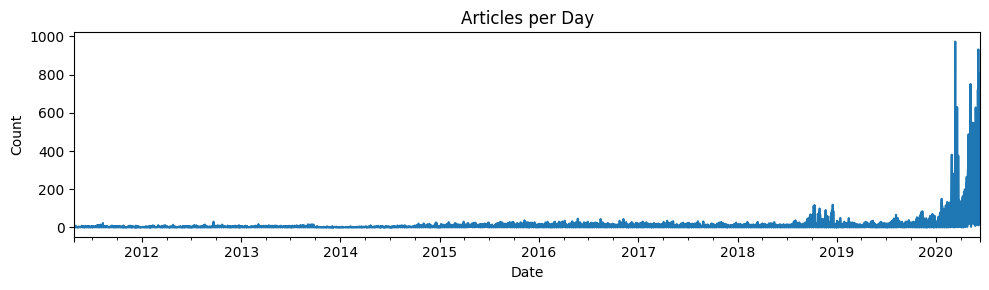

In [8]:
# Time series analysis
# Articles per day
daily_counts = df.set_index('publication_date').resample('D').size().rename('count')

# Top spike days (highest article counts)
top_spikes = daily_counts.sort_values(ascending=False).head(10)

# Hour of day distribution
df['hour'] = df['publication_date'].dt.hour
hour_counts = df['hour'].value_counts().sort_index()

print("Articles per day (non-zero):")
print(daily_counts[daily_counts>0].to_string())
print("\nTop spike days:")
print(top_spikes.to_string())
print("\nHour distribution (article counts by hour):")
print(hour_counts.to_string())

# Plot (matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
daily_counts.plot()
plt.title("Articles per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [9]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)  # keep only letters
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['clean_headline'] = df['headline'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Text analysis — keywords & topics

- Compute TF-IDF on cleaned headlines
- Use NMF to extract discoverable topics
- Show top words per topic and assign a dominant topic to each headline


In [10]:
# TF-IDF + NMF topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english', ngram_range=(1,2))
tfidf = vectorizer.fit_transform(df['clean_headline'])

# choose n_components based on size of dataset (start small: 3-10)
n_topics = 3
nmf = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=400)
W = nmf.fit_transform(tfidf)
H = nmf.components_
feature_names = vectorizer.get_feature_names_out()

def get_top_words(component, feature_names, topn=7):
    topn_ids = component.argsort()[:-topn-1:-1]
    return [feature_names[i] for i in topn_ids]

topics = {i: get_top_words(H[i], feature_names, topn=8) for i in range(n_topics)}
# Assign dominant topic per document
df['dominant_topic'] = W.argmax(axis=1)

print("Top words per topic:")
for tid, words in topics.items():
    print(f"Topic {tid}: {words}")

print("\nDominant topic counts:")
print(df['dominant_topic'].value_counts())


Top words per topic:
Topic 0: ['est', 'vs est', 'vs', 'eps', 'eps vs', 'reports', 'reports eps', 'sales vs']
Topic 1: ['stocks', 'stocks moving', 'moving', 'session', 'market session', 'pre market', 'pre', 'market']
Topic 2: ['earnings scheduled', 'scheduled', 'earnings', 'scheduled february', 'february', 'scheduled august', 'august', 'scheduled november']

Dominant topic counts:
dominant_topic
1    634331
0    522838
2    250159
Name: count, dtype: int64


## Publisher analysis

- Count number of articles per publisher
- If publisher strings are emails, extract domains to identify organizations


In [11]:
# Publisher analysis
# Top publishers (again)
top_publishers = df['publisher'].value_counts()

# Extract domain if publisher are urls/emails
def extract_domain(pub):
    if "@" in pub:
        return pub.split("@")[-1].lower()
    return pub.split("/")[0].lower()

df['publisher_domain'] = df['publisher'].apply(extract_domain)
domain_counts = df['publisher_domain'].value_counts()

print("Top publishers:")
print(top_publishers.to_string())

print("\nDomains (counts):")
print(domain_counts.to_string())


Top publishers:
publisher
Paul Quintaro                                     228373
Lisa Levin                                        186979
Benzinga Newsdesk                                 150484
Charles Gross                                      96732
Monica Gerson                                      82380
Eddie Staley                                       57254
Hal Lindon                                         49047
ETF Professor                                      28489
Juan Lopez                                         28438
Benzinga Staff                                     28114
Vick Meyer                                         24826
webmaster                                          20313
Benzinga_Newsdesk                                  19410
Zacks                                              19390
Jayson Derrick                                     19050
Allie Wickman                                      18317
Shanthi Rexaline                                   16640
Craig

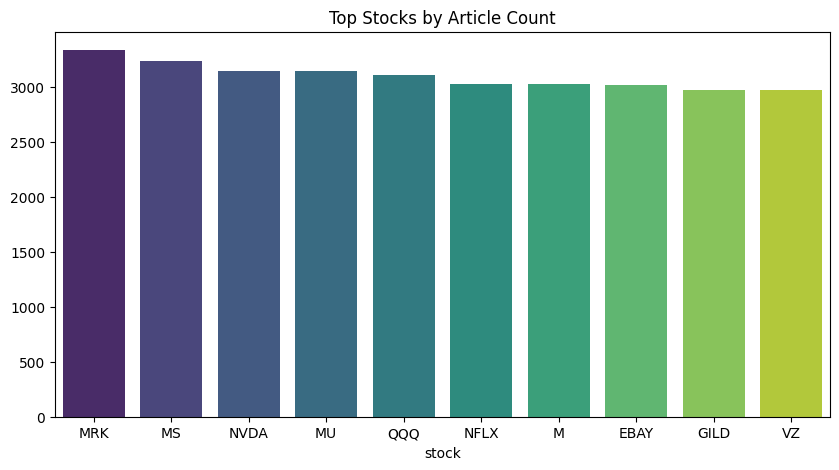

In [12]:
top_stocks = df['stock'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_stocks.index,
    y=top_stocks.values,
    hue=top_stocks.index,     # assign hue
    legend=False,             # hide legend
    palette='viridis'
)
plt.title('Top Stocks by Article Count')
plt.show()
